# From AR-Sandbox to PDE sim

Idea: use Sandbox DEM as parameter field for PDE simulation and project results back on surface

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

In [2]:
%matplotlib inline

## Load Sandbox DEMs

Note: these are presaved DEMs - for final version: update on basis of actual grid (write appropriate function)

In [9]:
data_dir = "../data/saved_DEMs/"
# find all npz files in data directory - check first, just in case:
dem_files = []
for f in os.listdir(data_dir):
    if os.path.splitext(f)[1] == '.npz':
        dem_files.append(f)
        
dem1 = np.load(os.path.join(data_dir, dem_files[0]))
        
# determine size:
nx, ny = dem1['arr_0'].shape
n_dems = len(dem_files)

sandbox_dems = np.empty((n_dems, nx, ny))

for i,f in enumerate(dem_files):
    dem_tmp = np.load(os.path.join(data_dir, f))
    sandbox_dems[i,:,:] = dem_tmp['arr_0']

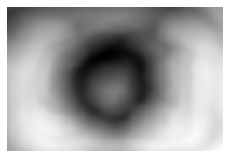

In [10]:
fig = plt.figure(frameon=False)
w = 3.
h = 2.
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(sandbox_dems[5], aspect='auto', cmap='gray')
# plt.savefig("ar_dem_5_gray.png", dpi=300)

## Define FD simulation for 2-D Poisson eqn

Example from "Sparse_grid_5_point.ipynb" from NRE class (which is adapted from scipy benchmark page)

In [11]:
from scipy import sparse  # to define sparse matrices
import scipy.sparse.linalg as ssl

In [12]:
# From scipy benchmark page:
from scipy.sparse import (csr_matrix, coo_matrix, dia_matrix, lil_matrix,
                              dok_matrix, rand, SparseEfficiencyWarning)

def poisson2d(N, M, dtype='d', format='csc'):
    """
    Return a sparse matrix for the 2D Poisson problem
    with standard 5-point finite difference stencil on a
    square N-by-N grid.
    """
    if N == 1:
        diags = np.asarray([[4]], dtype=dtype)
        return dia_matrix((diags, [0]), shape=(1, 1)).asformat(format)

    offsets = np.array([0, -N, N, -1, 1])

    diags = np.empty((5, N*M), dtype=dtype)

    diags[0] = -4  # main diagonal (note: in example it is 4)
    diags[1:] = 1  # all offdiagonals (note: in example, it is -1!)
    
    print(N,M)
    
    # set Neumann BCs
    # diags[1, N-1::N] = 2
    diags[3, N-2::N] = 2
    # diags[1, (N-1)**2:(N-1)**2+N] = 2
    # diags[2, :2*N] = 2
    diags[4, 1::N] = 2
    # diags[3, (N-1)*N:] =2
    
    # diags[3, :] = 2
    
    # as before:
    diags[3, N-1::N] = 0  # first lower diagonal
    diags[4, N::N] = 0  # first upper diagonal
    
    # print(diags)

    return dia_matrix((diags, offsets), shape=(N*M, N*M)).asformat(format)



In [13]:
# Apply to poisson problem with appropriate BC's:
n = 100
m = 50
T = poisson2d(n, m)

100 50


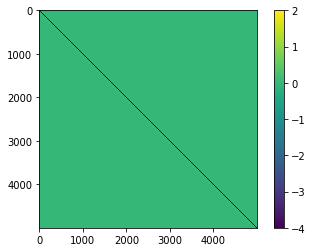

In [14]:
plt.imshow(T.todense())
plt.colorbar()

In [15]:
# set value with boundary conditions
b = np.zeros(n * m)
b_val = 20
b[:n] = -b_val
b[-n:] = b_val

print(b)

# b[::n] -= b_val
# b[n-1::n] -= b_val

# b[:n] += 5
# b[-n:] += 5

[-20. -20. -20. ...  20.  20.  20.]


In [16]:
# solve
u = ssl.spsolve(T, b)

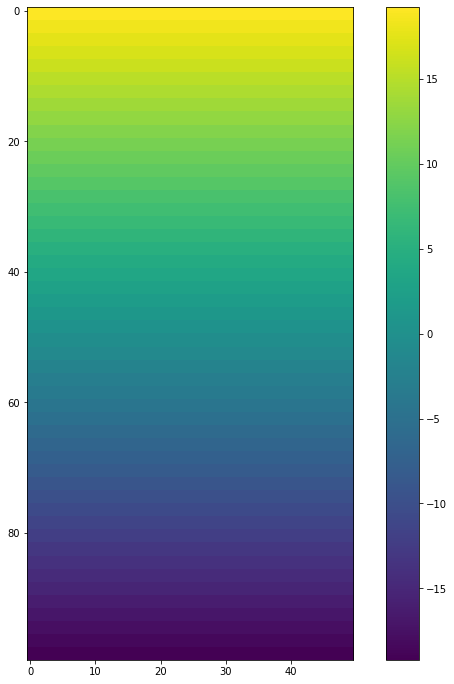

In [17]:
x = np.linspace(0, 10, n)
y = np.linspace(0, 10, m)
X,Y = np.meshgrid(x,y)
u2 = u.reshape(n,m)
fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, u2, cmap='viridis', cstride=2, rstride=2) # my new favourite colormap

plt.imshow(u2)
plt.colorbar()

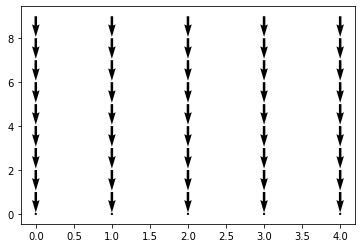

In [18]:
grad = np.gradient(u2)
plt.quiver(np.gradient(u2)[1][::10,::10],  np.gradient(u2)[0][::10,::10])

In [19]:
grad[0].shape

(100, 50)

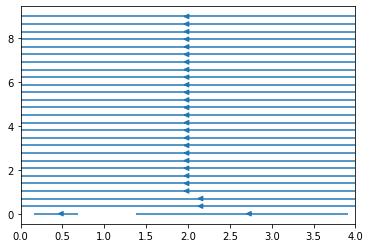

In [20]:
x = np.arange(int(m/10))
y = np.arange(int(n/10))
X,Y = np.meshgrid(x,y)

plt.streamplot(X, Y, np.gradient(u2)[0][::10,::10], np.gradient(u2)[1][::10,::10])

In [21]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


## Adjust parameter fields

First test: use a simple rectangular inhomogeneity in center

In [22]:
n = 150
m = 200 
params = np.ones((n,m))
# params[50:100, 75:125] = 2

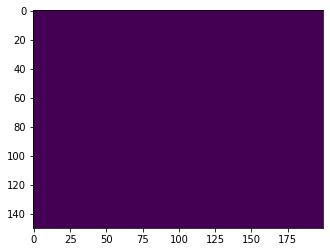

In [23]:
plt.imshow(params)

In [24]:
def poisson2d_param(N, M, params, dtype='d', format='csc'):
    """
    Return a sparse matrix for the 2D Poisson problem
    with standard 5-point finite difference stencil on a
    square N-by-N grid.
    
    Consider heterogeneities in parameter field (argument params)
    """
    if N == 1:
        diags = np.asarray([[4]], dtype=dtype)
        return dia_matrix((diags, [0]), shape=(1, 1)).asformat(format)

    offsets = np.array([0, -N, N, -1, 1])

    diags = np.empty((5, N*M), dtype=dtype)

    diags[0] = -4  # main diagonal (note: in example it is 4)
    diags[1:] = 1  # all offdiagonals (note: in example, it is -1!)
        
    # temper with parameter fields:
    diags[0] = - 4 * np.ravel(params)
    
    # param_frame = np.ones_like(params) * 4.
    # param_frame[1:-1, 1:-1] = params[:-2, 1:-1] + params[2:, 1:-1] + params[1:-1, 2:] + params[1:-1, :-2]
    
    param_comb = params[:-2, 1:-1] + params[2:, 1:-1] + params[1:-1, 2:] + params[1:-1, :-2]
    param_frame = np.pad(param_comb, (1,1), 'edge')
    
    order_flag = 'F'   # {'C','F', 'A', 'K'}
    
    diags[0] = - np.ravel(param_frame, order=order_flag)
    
    # print(diags[0])
    
    diags[1] = np.ravel(params, order=order_flag)
    diags[2] = np.ravel(params, order=order_flag)
    diags[3] = np.ravel(params, order=order_flag)
    diags[4] = np.ravel(params, order=order_flag)
    
    # set Neumann BCs
    # diags[1, N-1::N] = 2
    diags[3, N-2::N] = 2 * diags[3, N-2::N]
    # diags[1, (N-1)**2:(N-1)**2+N] = 2
    # diags[2, :2*N] = 2
    diags[4, 1::N] = 2 * diags[4, 1::N]
    # diags[3, (N-1)*N:] =2
    
    # diags[3, :] = 2
    
    # as before:
    diags[3, N-1::N] = 0  # first lower diagonal
    diags[4, N::N] = 0  # first upper diagonal
    
    # print(diags)

    return dia_matrix((diags, offsets), shape=(N*M, N*M)).asformat(format)



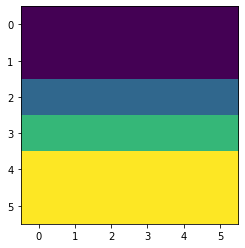

In [25]:
xx = np.arange(1,5)
xxx = np.meshgrid(xx,xx)
xxxx = np.pad(xxx[1], (1,1), 'edge')
plt.imshow(xxxx)

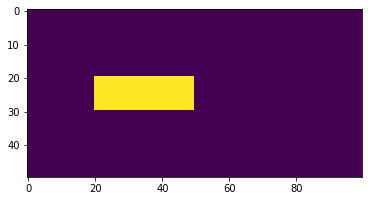

In [26]:
n = 50
m = 100
params = np.ones((n,m))
# params[50:100, 75:125] = 2
params[20:30, 20:50] = 10
plt.imshow(params)

In [27]:
T = poisson2d_param(n,m, params)

In [28]:
# set value with boundary conditions
b = np.zeros(n * m)
b_val = 20
b[:n] = -b_val
b[-n:] = b_val

In [29]:
# solve
u = ssl.spsolve(T, b)

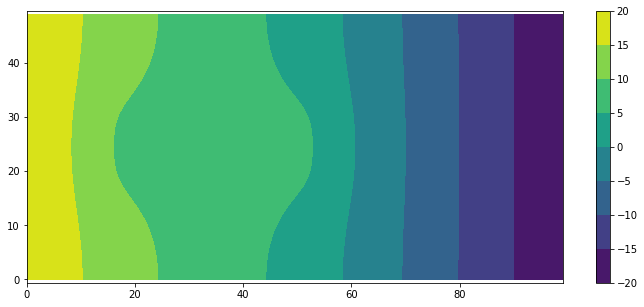

In [30]:
x = np.linspace(0, 10, n)
y = np.linspace(0, 10, m)
X,Y = np.meshgrid(x,y)
u2 = u.reshape(m,n)
fig = plt.figure(figsize=(12,5))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, u2, cmap='viridis', cstride=2, rstride=2) # my new favourite colormap

plt.contourf(u2.T)
plt.axis('equal')
plt.colorbar()

(0.0, 105.0, 0.0, 52.5)

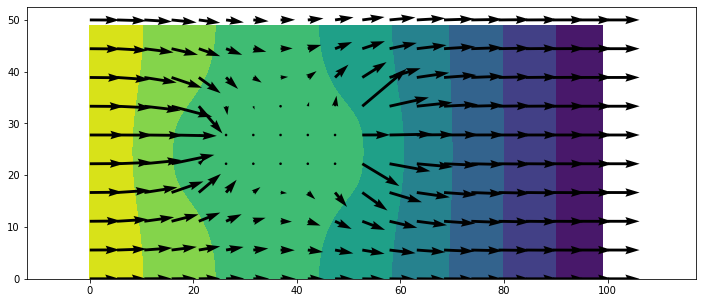

In [31]:
grad = np.gradient(u2.T)
n_steps = 5
x = np.linspace(0,m,int(m/n_steps))
y = np.linspace(0,n,int(n/n_steps))
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(12,5))
plt.contourf(u2.T)
plt.quiver(X, Y, -np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])
plt.axis('equal')

In [32]:

plt.quiver?

In [33]:
np.linspace(0,m,10)

array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
        44.44444444,  55.55555556,  66.66666667,  77.77777778,
        88.88888889, 100.        ])

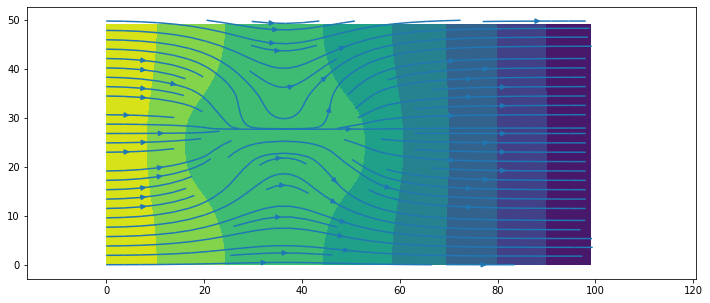

In [34]:
x = np.linspace(0,m,int(m/n_steps))
y = np.linspace(0,n,int(n/n_steps))
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(12,5))
plt.contourf(u2.T)
# plt.quiver(X, Y, -np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])
plt.axis('equal')
plt.streamplot(X, Y,-np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])

## DEM from Sandbox as parameter field

In [35]:
n = 150
m = 200 
params = np.ones((n,m))
# params[50:100, 75:125] = 2

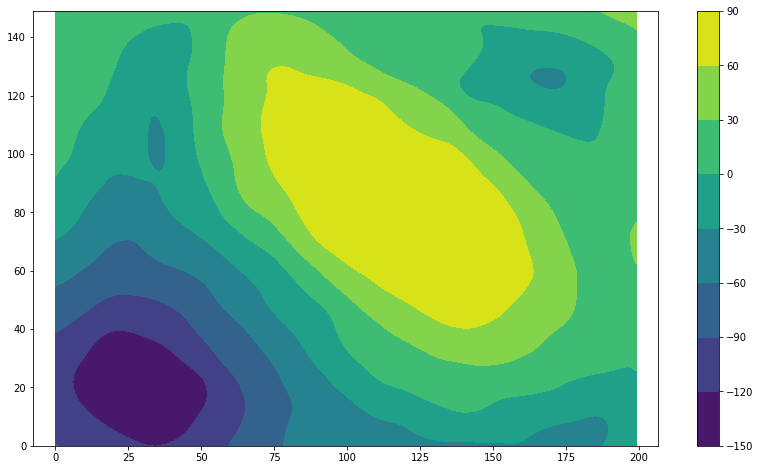

In [36]:
dem_id = 6
fig = plt.figure(figsize=(14,8))

plt.contourf(sandbox_dems[dem_id,:,:])
plt.axis('equal')
plt.colorbar()

Let's scale to something smaller (and positive...):

In [37]:
params = 1 + (sandbox_dems[dem_id,:,:] - np.min(sandbox_dems[dem_id,:,:])) /\
(np.max(sandbox_dems[dem_id,:,:]) - np.min(sandbox_dems[dem_id,:,:]))

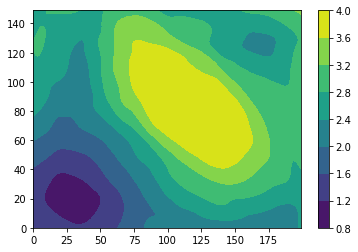

In [38]:
plt.contourf(params**2)
plt.colorbar()

Now, let's run the simulation:

In [39]:
# params = np.ones((n,m))
# params[50:100, 75:125] = 2
# params[20:30, 20:50] = 10
# plt.imshow(params)

In [40]:

T = poisson2d_param(n, m, params**2)

In [41]:
# set value with boundary conditions
b = np.zeros(n * m)
b_val = 20
b[:n] = -b_val
b[-n:] = b_val

In [42]:
# solve
u = ssl.spsolve(T, b)

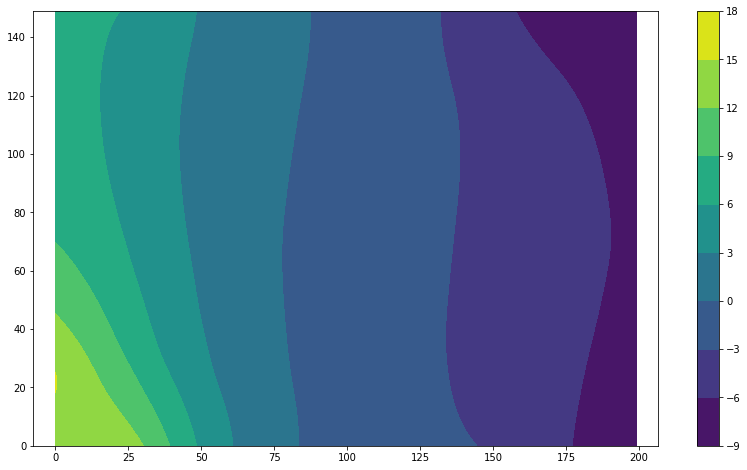

In [43]:
x = np.linspace(0, 10, n)
y = np.linspace(0, 10, m)
X,Y = np.meshgrid(x,y)
u2 = u.reshape(m,n)
# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, u2, cmap='viridis', cstride=2, rstride=2) # my new favourite colormap

fig = plt.figure(figsize=(14,8))
# 
# plt.contourf(sandbox_dems[dem_id,:,:])
plt.contourf(u2.T)
plt.axis('equal')
plt.colorbar()

(0.0, 210.0, 0.0, 157.5)

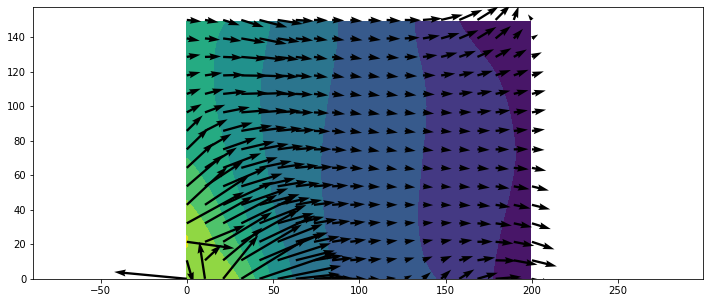

In [44]:
grad = np.gradient(u2.T)
n_steps = 10
x = np.linspace(0,m,int(m/n_steps))
y = np.linspace(0,n,int(n/n_steps))
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(12,5))
plt.contourf(u2.T)
plt.quiver(X, Y, -np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])
plt.axis('equal')

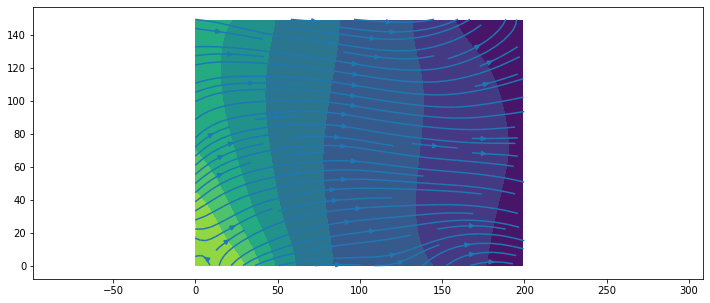

In [45]:
x = np.linspace(0,m,int(m/n_steps))
y = np.linspace(0,n,int(n/n_steps))
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(12,5))
plt.contourf(u2.T)
# plt.quiver(X, Y, -np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])
plt.axis('equal')
plt.streamplot(X, Y,-np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])

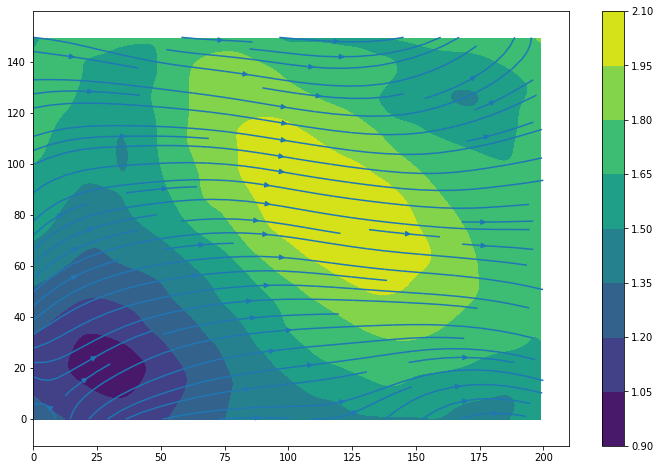

In [46]:
x = np.linspace(0,m,int(m/n_steps))
y = np.linspace(0,n,int(n/n_steps))
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(12,8))
# plt.contourf(u2.T)
plt.contourf(params)
plt.colorbar()
# plt.quiver(X, Y, -np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])
plt.axis('equal')
plt.streamplot(X, Y,-np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])

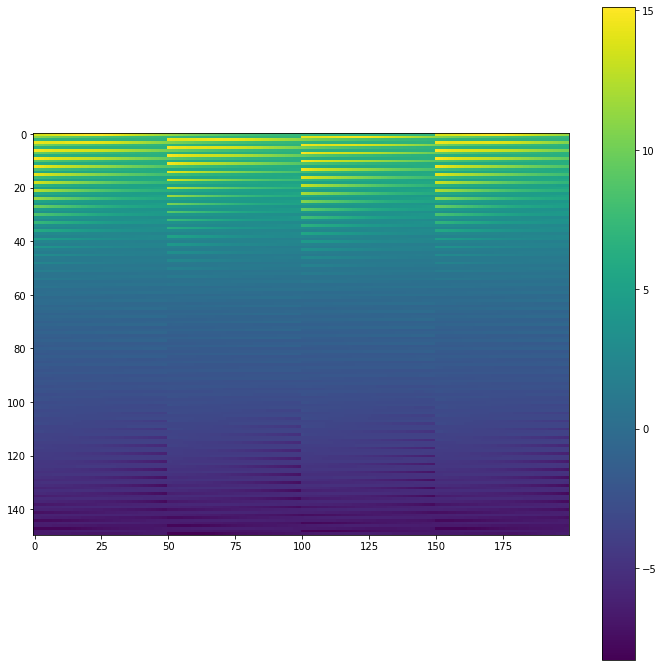

In [47]:
x = np.linspace(0, 10, n)
y = np.linspace(0, 10, m)
X,Y = np.meshgrid(x,y)
u2 = u.reshape(n,m)
fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, u2, cmap='viridis', cstride=2, rstride=2) # my new favourite colormap

plt.imshow(u2)
plt.colorbar()

In [48]:
np.ravel?

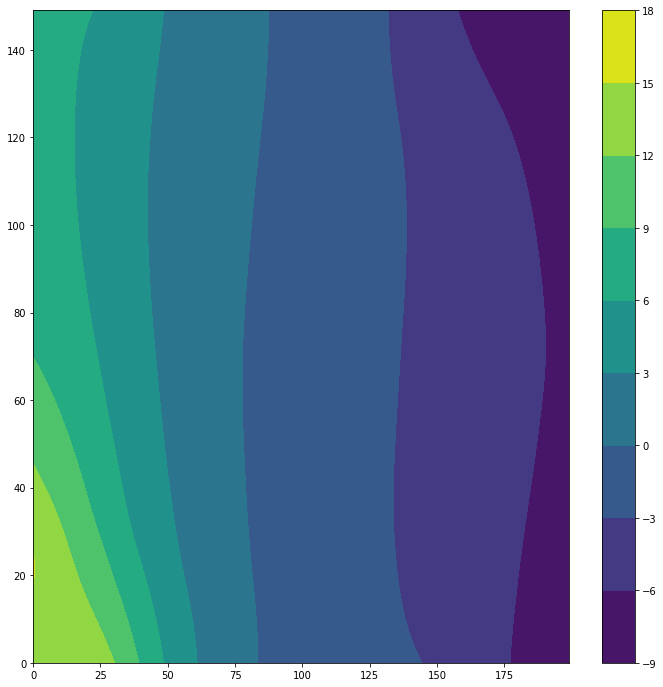

In [49]:
x = np.linspace(0, 10, n)
y = np.linspace(0, 10, m)
X,Y = np.meshgrid(x,y)
u2 = u.reshape(m,n)
fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, u2, cmap='viridis', cstride=2, rstride=2) # my new favourite colormap

plt.contourf(u2.T)
plt.colorbar()

## Now: all in functions

(Note: with some hardcoded sections...)

In [54]:
def scale_dem(sandbox_dem):
    params = 1 + (sandbox_dem - np.min(sandbox_dem)) /\
    (np.max(sandbox_dem) - np.min(sandbox_dem))
    return params**2

def run_sim(params):
    n = 150
    m = 200 
    T = poisson2d_param(n, m, params)
    # set value with boundary conditions
    b = np.zeros(n * m)
    b_val = 20
    b[:n] = -b_val
    b[-n:] = b_val
    # solve
    u = ssl.spsolve(T, b)
    u2 = u.reshape(m,n)
    return u2

def plot_field(u):
    n,m = u.shape
    x = np.linspace(0, 10, n)
    y = np.linspace(0, 10, m)
    X,Y = np.meshgrid(x,y)
    # fig = plt.figure(figsize=(12,12))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(X, Y, u2, cmap='viridis', cstride=2, rstride=2) # my new favourite colormap

    fig = plt.figure(figsize=(14,8))
    # 
    # plt.contourf(sandbox_dems[dem_id,:,:])
    plt.contourf(u.T, 25, cmap='RdBu')
    plt.axis('equal')
    plt.colorbar()
    plt.xlim([0,200])
    plt.ylim([0,150])
    plt.tight_layout()

def plot_quiver(u):
    n,m = u.shape
    n_steps = 10
    y = np.linspace(0,m,int(m/n_steps))
    x = np.linspace(0,n,int(n/n_steps))
    X,Y = np.meshgrid(x,y)

    fig = plt.figure(figsize=(12,8))
    plt.contourf(params, 25)
    plt.quiver(X, Y, -np.gradient(u)[0][::n_steps,::n_steps],  -np.gradient(u)[1][::n_steps,::n_steps])
    plt.axis('equal')
    plt.xlim([0,200])
    plt.ylim([0,150])
    plt.tight_layout()

def plot_streamlines(u, plot_lines=True, savefig=False, fig_filename="dtm_streamlines.png"):
    n,m = u.shape
    y = np.linspace(0,m,int(m/n_steps))
    x = np.linspace(0,n,int(n/n_steps))
    X,Y = np.meshgrid(x,y)

    fig = plt.figure(figsize=(12,8))
    # plt.contourf(u2.T)
    plt.contourf(params, 25)
    plt.colorbar()
    # plt.quiver(X, Y, -np.gradient(u2)[0].T[::n_steps,::n_steps],  -np.gradient(u2)[1].T[::n_steps,::n_steps])
    plt.axis('equal')
    speed = 1/np.sqrt(np.gradient(u)[0].T[::n_steps,::n_steps]**2 + np.gradient(u)[1].T[::n_steps,::n_steps]**2)
    lw = 10*speed / speed.max()
    if plot_lines:
        plt.streamplot(X, Y,-np.gradient(u)[0].T[::n_steps,::n_steps],  -np.gradient(u)[1].T[::n_steps,::n_steps],
                      linewidth=lw,
                      color='w',
                       arrowsize = 2.,
                      integration_direction='forward')
    plt.xlim([0,200])
    plt.ylim([0,150])
    plt.tight_layout()
    if savefig:
        plt.savefig(fig_filename)

### Example sim

In [66]:
# define here Sandbox DEM
dem_id = 3
sandbox_dem = sandbox_dems[dem_id,:,:]

In [67]:
params = scale_dem(sandbox_dem)
u = run_sim(params)

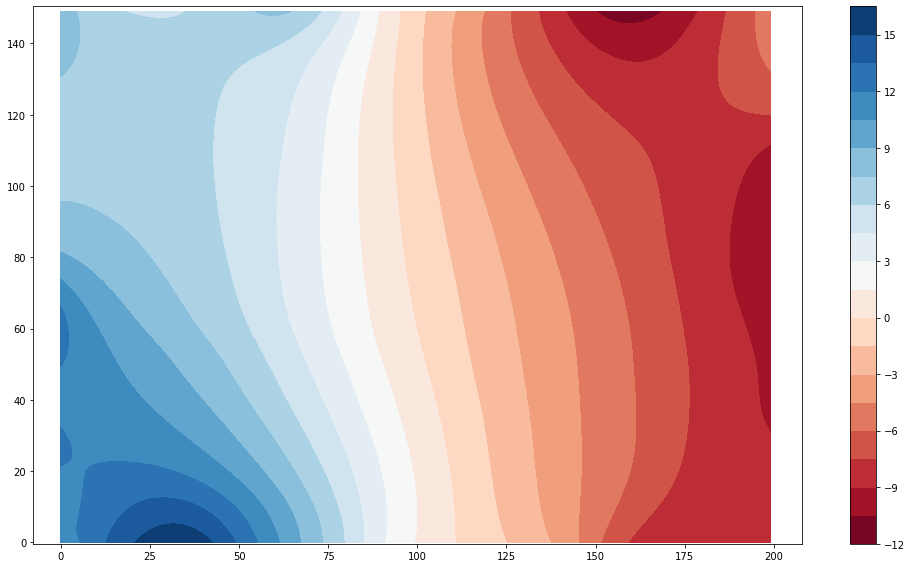

In [68]:
plot_field(u)

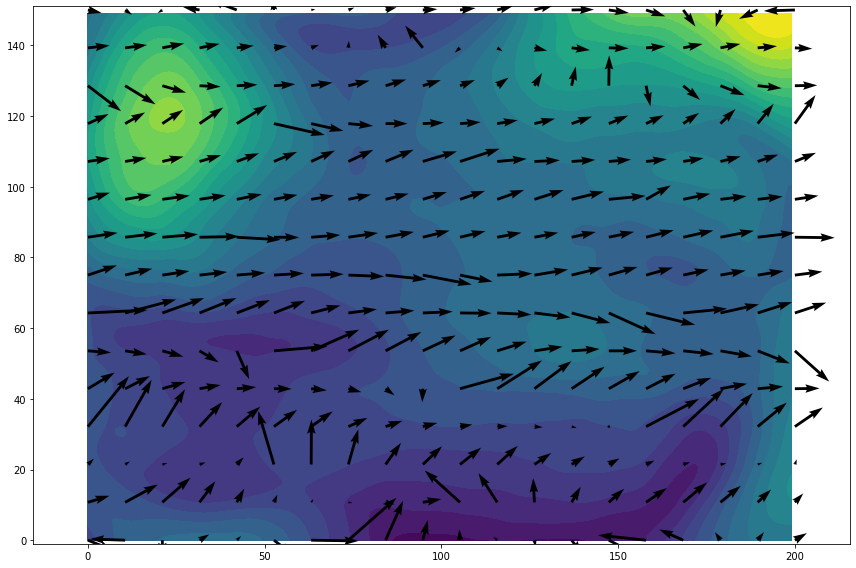

In [69]:
plot_quiver(u)

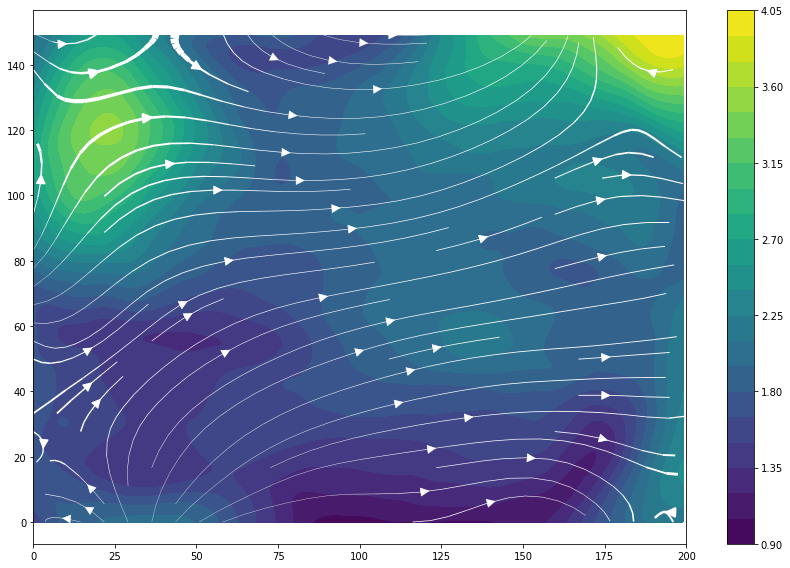

In [70]:
plot_streamlines(u, 
                 plot_lines=True,
                 savefig=True,
                # fig_filename="Sandbox_DTM_param_field_and_streamlines.png")
                fig_filename="Sandbox_DTM_param_field.png")